In [31]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## 1. Data Overview

In [4]:
df = pd.read_csv("data/initiatives.csv")
df

,Initiative,Cost ($),Engineering Days,ARR Impact (%),Churn Reduction (%),Confidence
0,Subscription Tracker,50000,15,5,2,High
1,Savings Coach AI,70000,25,8,3,Medium
2,US Expansion Campaign,100000,10,12,0,Low
3,In-app Rewards,30000,8,4,2,Medium
4,Churn Reactivation Flow,40000,12,3,5,High
5,Smart Budget Nudges,45000,10,4,4,High
6,Credit Score Booster Tips,35000,6,3,2,Medium
7,LLM-based Financial Coach,100000,30,11,2,Low
8,Friends Savings Challenge,25000,5,3,3,Medium


In [6]:
from simulator.config import BASE_ARR, CONFIDENCE_MULTIPLIER

In [17]:
df["Confidence Multiplier"] = df["Confidence"].map(CONFIDENCE_MULTIPLIER)
df["Expected ARR Impact ($)"] = BASE_ARR * (df["ARR Impact (%)"]/100)* df["Confidence Multiplier"]
df["ROI"] = (df["Expected ARR Impact ($)"] - df["Cost ($)"]) / df["Cost ($)"].round(2)
df

,Initiative,Cost ($),Engineering Days,ARR Impact (%),Churn Reduction (%),Confidence,Confidence Multiplier,Expected ARR Impact ($),ROI
0,Subscription Tracker,50000,15,5,2,High,1.00,500000.0,9.000000
1,Savings Coach AI,70000,25,8,3,Medium,0.75,600000.0,7.571429
2,US Expansion Campaign,100000,10,12,0,Low,0.50,600000.0,5.000000
3,In-app Rewards,30000,8,4,2,Medium,0.75,300000.0,9.000000
4,Churn Reactivation Flow,40000,12,3,5,High,1.00,300000.0,6.500000
5,Smart Budget Nudges,45000,10,4,4,High,1.00,400000.0,7.888889
6,Credit Score Booster Tips,35000,6,3,2,Medium,0.75,225000.0,5.428571
7,LLM-based Financial Coach,100000,30,11,2,Low,0.50,550000.0,4.500000
8,Friends Savings Challenge,25000,5,3,3,Medium,0.75,225000.0,8.000000


/tmp/ipykernel_40214/2460102416.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/home/ilse/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


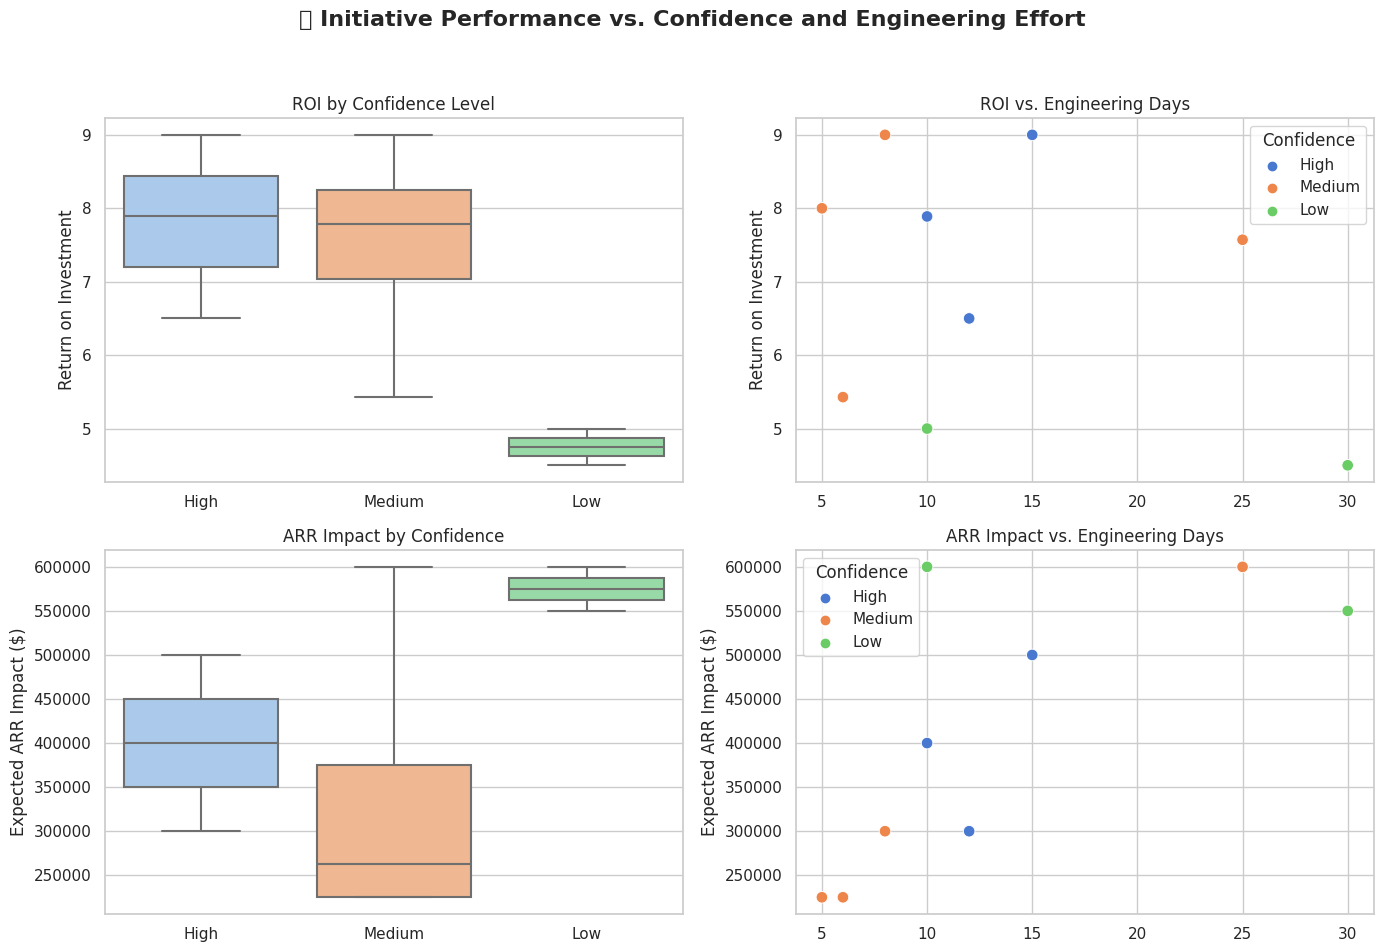

In [27]:
# vizualization plots
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("📊 Initiative Performance vs. Confidence and Engineering Effort", fontsize=16, fontweight='bold')

# --- ROI by Confidence ---
sns.boxplot(data=df, x="Confidence", y="ROI", ax=axes[0, 0], palette="pastel")
axes[0, 0].set_title("ROI by Confidence Level")
axes[0, 0].set_ylabel("Return on Investment")

# --- ROI vs Engineering Days (continuous) ---
sns.scatterplot(data=df, x="Engineering Days", y="ROI", hue="Confidence", ax=axes[0, 1], palette="muted", s=70)
axes[0, 1].set_title("ROI vs. Engineering Days")
axes[0, 1].set_ylabel("Return on Investment")

# --- ARR by Confidence ---
sns.boxplot(data=df, x="Confidence", y="Expected ARR Impact ($)", ax=axes[1, 0], palette="pastel")
axes[1, 0].set_title("ARR Impact by Confidence")
axes[1, 0].set_ylabel("Expected ARR Impact ($)")

# --- ARR vs Engineering Days (continuous) ---
sns.scatterplot(data=df, x="Engineering Days", y="Expected ARR Impact ($)", hue="Confidence", ax=axes[1, 1], palette="muted", s=70)
axes[1, 1].set_title("ARR Impact vs. Engineering Days")
axes[1, 1].set_ylabel("Expected ARR Impact ($)")

# --- Final formatting ---
for ax in axes.flat:
    ax.set_xlabel("")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

ROI by confidence level:
- High & Medium confidence initiatives have a much higher median ROI (~7.5–8) compared to Low confidence, which clusters around ~5.
- The spread is larger for High/Medium, suggesting more variance in success, but also higher upside.
- Low confidence initiatives appear consistently low ROI — very little upside or variation.

ROI by engineering days:
- There's no strong linear relationship between engineering effort and ROI.
- High ROI can come from both low and mid engineering days.
- Low-confidence initiatives are towards the bottom (low ROI), regardless of engineering effort.

ARR by confidence level:
- High-confidence initiatives tend to have both higher median and upper-bound ARR impact.
- Medium confidence initiatives have more spread and lower ARR.
- Low confidence initiatives have high ARR too — but paired with low ROI (top-left chart).

ARR by engineering days:
- Higher ARR does often require more engineering days (but not always). 
- There are a few standout low-effort / high-impact initiatives — rare but highly valuable.
- Low-confidence initiatives also show up at the top of ARR — but recall from above: low ROI!

In [23]:
df.nlargest(5, "ROI")[["Initiative", "ROI", "Expected ARR Impact ($)"]]

,Initiative,ROI,Expected ARR Impact ($)
0,Subscription Tracker,9.000000,500000.0
3,In-app Rewards,9.000000,300000.0
8,Friends Savings Challenge,8.000000,225000.0
5,Smart Budget Nudges,7.888889,400000.0
1,Savings Coach AI,7.571429,600000.0


## 2. Setup Distributions - Based on Confidence

In [28]:
# mapping standard deviations for confidence (low risk = narrow distribution, high risk is wide distribution)
confidence_to_std = {
    "High": 0.10,
    "Medium": 0.20,
    "Low": 0.40
}

In [33]:
df["ARR_std"] = df.apply(
    lambda row: row["Expected ARR Impact ($)"] * confidence_to_std[row["Confidence"]],
    axis=1
)

In [35]:
df

,Initiative,Cost ($),Engineering Days,ARR Impact (%),Churn Reduction (%),Confidence,Confidence Multiplier,Expected ARR Impact ($),ROI,ARR_std
0,Subscription Tracker,50000,15,5,2,High,1.00,500000.0,9.000000,50000.0
1,Savings Coach AI,70000,25,8,3,Medium,0.75,600000.0,7.571429,120000.0
2,US Expansion Campaign,100000,10,12,0,Low,0.50,600000.0,5.000000,240000.0
3,In-app Rewards,30000,8,4,2,Medium,0.75,300000.0,9.000000,60000.0
4,Churn Reactivation Flow,40000,12,3,5,High,1.00,300000.0,6.500000,30000.0
5,Smart Budget Nudges,45000,10,4,4,High,1.00,400000.0,7.888889,40000.0
6,Credit Score Booster Tips,35000,6,3,2,Medium,0.75,225000.0,5.428571,45000.0
7,LLM-based Financial Coach,100000,30,11,2,Low,0.50,550000.0,4.500000,220000.0
8,Friends Savings Challenge,25000,5,3,3,Medium,0.75,225000.0,8.000000,45000.0


In [34]:
# For one initiative
np.random.normal(loc=row["Expected ARR Impact ($)"], scale=row["ARR_std"], size=1000)

NameError: name 'row' is not defined